In [1]:
!pip install transformers

In [2]:
import pandas as pd
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Importing RoBERTa 

In [3]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [4]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

## Twitter

In [5]:
df = pd.read_csv('/kaggle/input/twitter-and-reddit-sentimental-analysis-dataset/Twitter_Data.csv')
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


#### Adding column name ID, to help in further work

In [6]:
df = df.reset_index().rename(columns={'index': 'ID'})
df.head()

,ID,clean_text,category
0,0,when modi promised “minimum government maximum...,-1.0
1,1,talk all the nonsense and continue all the dra...,0.0
2,2,what did just say vote for modi welcome bjp t...,1.0
3,3,asking his supporters prefix chowkidar their n...,1.0
4,4,answer who among these the most powerful world...,1.0


In [7]:
df.shape

(162980, 3)

#### We will just work on first 1000 tweets

In [8]:
df = df.head(1000)

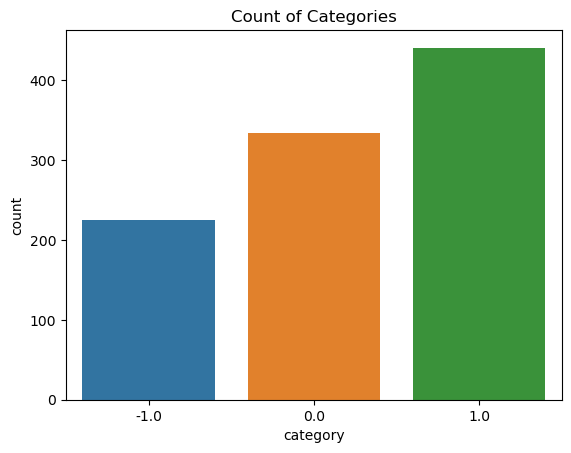

In [9]:
sns.countplot(x = df['category'])
plt.title('Count of Categories')
plt.show()

#### The function that will return RoBERTa base score

In [10]:
def polarity_score(text):
    encoded_text = tokenizer(text, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'negative' : scores[0],
        'neutral' : scores[1],
        'positive' : scores[2]
    }
    return scores_dict

In [11]:
final_output = {}

for i, row in tqdm(df.iterrows(), total=len(df)):
    try: #some text may break, hence to jump over it we use try-except
        text = row['clean_text']
        myid = row['ID']
        result = polarity_score(str(text))
        final_output[myid] = {**result}
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/1000 [00:00<?, ?it/s]

In [12]:
twitter_result = pd.DataFrame(final_output)
twitter_result.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
negative,0.509937,0.687368,0.139315,0.619901,0.018885,0.122196,0.012987,0.083578,0.029796,0.523434,...,0.435547,0.906052,0.842763,0.003610,0.085271,0.063147,0.819152,0.826349,0.446952,0.702099
neutral,0.459676,0.291328,0.755941,0.346615,0.571666,0.813550,0.764785,0.852778,0.673527,0.460013,...,0.543041,0.090901,0.151335,0.288915,0.413539,0.330405,0.173683,0.165905,0.534905,0.277118
positive,0.030387,0.021304,0.104743,0.033484,0.409448,0.064254,0.222228,0.063644,0.296677,0.016553,...,0.021411,0.003047,0.005902,0.707475,0.501190,0.606448,0.007164,0.007746,0.018143,0.020783


In [13]:
twitter_result = twitter_result.T
twitter_result.head()

,negative,neutral,positive
0,0.509937,0.459676,0.030387
1,0.687368,0.291328,0.021304
2,0.139315,0.755941,0.104743
3,0.619901,0.346615,0.033484
4,0.018885,0.571666,0.409448


In [14]:
twitter_result = twitter_result.reset_index().rename(columns={'index': 'ID'})
twitter_result = twitter_result.merge(df, how='right')
twitter_result.head()

,ID,negative,neutral,positive,clean_text,category
0,0,0.509937,0.459676,0.030387,when modi promised “minimum government maximum...,-1.0
1,1,0.687368,0.291328,0.021304,talk all the nonsense and continue all the dra...,0.0
2,2,0.139315,0.755941,0.104743,what did just say vote for modi welcome bjp t...,1.0
3,3,0.619901,0.346615,0.033484,asking his supporters prefix chowkidar their n...,1.0
4,4,0.018885,0.571666,0.409448,answer who among these the most powerful world...,1.0


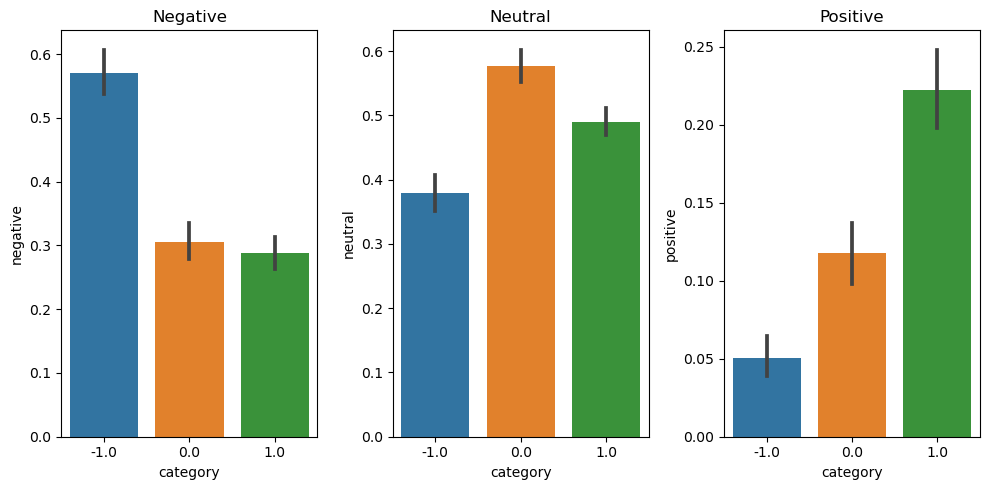

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
sns.barplot(data=twitter_result, x='category', y='negative', ax=axs[0])
sns.barplot(data=twitter_result, x='category', y='neutral', ax=axs[1])
sns.barplot(data=twitter_result, x='category', y='positive', ax=axs[2])
axs[0].set_title('Negative')
axs[1].set_title('Neutral')
axs[2].set_title('Positive')
plt.tight_layout()
plt.show()

# Reddit

In [16]:
df = pd.read_csv('/kaggle/input/twitter-and-reddit-sentimental-analysis-dataset/Reddit_Data.csv')
df.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [17]:
df = df.reset_index().rename(columns={'index': 'ID'})
df.head()

,ID,clean_comment,category
0,0,family mormon have never tried explain them t...,1
1,1,buddhism has very much lot compatible with chr...,1
2,2,seriously don say thing first all they won get...,-1
3,3,what you have learned yours and only yours wha...,0
4,4,for your own benefit you may want read living ...,1


In [18]:
df.shape

(37249, 3)

In [19]:
df = df.head(1000)

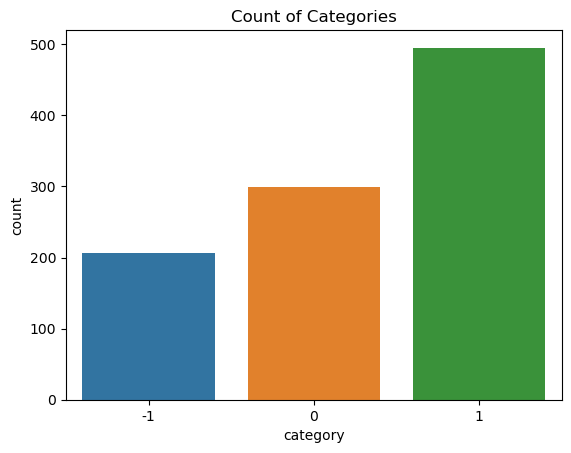

In [20]:
sns.countplot(x = df['category'])
plt.title('Count of Categories')
plt.show()

In [21]:
def polarity_score(text):
    encoded_text = tokenizer(text, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'negative' : scores[0],
        'neutral' : scores[1],
        'positive' : scores[2]
    }
    return scores_dict

In [22]:
final_output = {}

for i, row in tqdm(df.iterrows(), total=len(df)):
    try: #some text may break, hence to jump over it we use try-except
        text = row['clean_comment']
        myid = row['ID']
        result = polarity_score(str(text))
        final_output[myid] = {**result}
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Broke for id 271
Broke for id 916


In [23]:
reddit_result = pd.DataFrame(final_output)
reddit_result.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
negative,0.084351,0.116215,0.614741,0.093424,0.078506,0.020445,0.068959,0.105663,0.071025,0.037287,...,0.093160,0.209355,0.424715,0.165678,0.654070,0.687978,0.037322,0.607057,0.279182,0.381789
neutral,0.655359,0.681857,0.358791,0.827773,0.627023,0.717380,0.449837,0.824467,0.543146,0.467555,...,0.824729,0.622768,0.547739,0.644371,0.308018,0.291340,0.458011,0.379462,0.701014,0.584629
positive,0.260290,0.201928,0.026469,0.078804,0.294471,0.262175,0.481204,0.069871,0.385828,0.495158,...,0.082111,0.167878,0.027546,0.189951,0.037912,0.020682,0.504667,0.013482,0.019804,0.033582


In [24]:
reddit_result = reddit_result.T
reddit_result.head()

,negative,neutral,positive
0,0.084351,0.655359,0.260290
1,0.116215,0.681857,0.201928
2,0.614741,0.358791,0.026469
3,0.093424,0.827773,0.078804
4,0.078506,0.627023,0.294471


In [25]:
reddit_result = reddit_result.reset_index().rename(columns={'index': 'ID', '0': 'negative', '1': 'neutral', '2': 'positive'})
reddit_result = reddit_result.merge(df, how='right')
reddit_result.head()

,ID,negative,neutral,positive,clean_comment,category
0,0,0.084351,0.655359,0.260290,family mormon have never tried explain them t...,1
1,1,0.116215,0.681857,0.201928,buddhism has very much lot compatible with chr...,1
2,2,0.614741,0.358791,0.026469,seriously don say thing first all they won get...,-1
3,3,0.093424,0.827773,0.078804,what you have learned yours and only yours wha...,0
4,4,0.078506,0.627023,0.294471,for your own benefit you may want read living ...,1


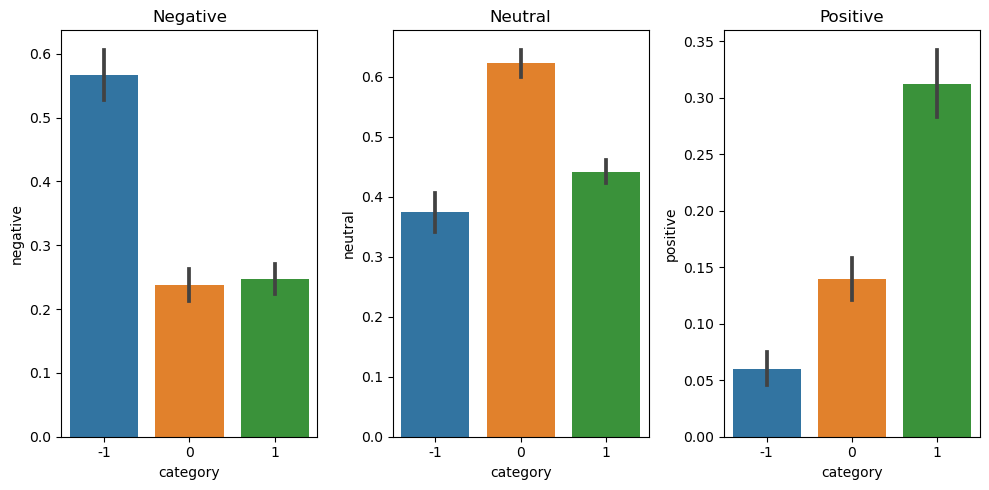

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
sns.barplot(data=reddit_result, x='category', y='negative', ax=axs[0])
sns.barplot(data=reddit_result, x='category', y='neutral', ax=axs[1])
sns.barplot(data=reddit_result, x='category', y='positive', ax=axs[2])
axs[0].set_title('Negative')
axs[1].set_title('Neutral')
axs[2].set_title('Positive')
plt.tight_layout()
plt.show()